**Когортный анализ**

Проведем когортный анализ клиентов федерального интернет-магазина детских товаров на основе измененных, но приближенных к реальности данных, которые были предоставлены нв рамках обучения на портале GeekBrains.

In [283]:
import pandas as pd
from datetime import datetime
import matplotlib

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np

In [284]:
matplotlib.rcParams['figure.figsize'] =  [12.0, 8.0]

In [ ]:
#Загрузим данные с учетом разделителя и типа данных для дат

In [285]:
to_datetime = lambda d: datetime.strptime(d, '%d.%m.%Y')

In [286]:
df = pd.read_csv('orders_20190822.csv', sep=';', encoding='utf-8', decimal = ',', converters={'o_date': to_datetime})

In [287]:
df.head()

,id_o,user_id,price,o_date
0,1234491,337544,539.0,2016-01-01
1,1234494,171642,153.3,2016-01-01
2,1234497,260596,55.3,2016-01-01
3,1234498,1105609,752.5,2016-01-01
4,1234500,982696,4410.0,2016-01-01


In [288]:
#Так как мы делаем ежемесячный когортный анализ, создадим отдельную колонку с годом и месяцем покупки
df['o_period'] = df.o_date.apply(lambda x: x.strftime('%Y-%m'))

In [289]:
df.head()

,id_o,user_id,price,o_date,o_period
0,1234491,337544,539.0,2016-01-01,2016-01
1,1234494,171642,153.3,2016-01-01,2016-01
2,1234497,260596,55.3,2016-01-01,2016-01
3,1234498,1105609,752.5,2016-01-01,2016-01
4,1234500,982696,4410.0,2016-01-01,2016-01


In [290]:
#Поставим в качестве индекса user_id
df.set_index('user_id', inplace=True)
#Возьмем минимальную дату и создадим когортную группу, которая ей будет соответствовать по году и месяцу
df['cohortgroup'] = df.groupby(level=0)['o_date'].min().apply(lambda x: x.strftime('%Y-%m'))
#Восстановим индекс
df.reset_index(inplace=True)

In [291]:
#Теперь каждому уникальному пользователю соответствует месяц и год его первой покупки
df.tail()

,user_id,id_o,price,o_date,o_period,cohortgroup
2002799,5806002,6945524,825.3,2017-12-31,2017-12,2017-12
2002800,5919142,6945526,4934.3,2017-12-31,2017-12,2017-12
2002801,1574166,6945527,804.3,2017-12-31,2017-12,2016-06
2002802,5919156,6945528,5019.7,2017-12-31,2017-12,2017-12
2002803,4801083,6945534,679.7,2017-12-31,2017-12,2017-10


In [292]:
# посчитаем количество уникальных клиентов, покупок и их сумму на каждую группу и период 
grouped = df.groupby(['cohortgroup', 'o_period'])
cohorts = grouped.agg({'user_id': pd.Series.nunique,
                       'id_o': pd.Series.nunique,
                       'price': np.sum})

In [293]:
cohorts.head()

user_id   id_o         price
cohortgroup o_period                              
2016-01     2016-01     35225  46559  9.681233e+07
            2016-02      6061  12400  2.546869e+07
            2016-03      6469  14044  2.561764e+07
            2016-04      6142  14091  2.666818e+07
            2016-05      4927  10882  1.985025e+07

In [294]:
# переименуем колонки по их значению 'totalusers', totalorders' и  'totalsum'
cohorts.rename(columns={'user_id': 'totalusers','id_o': 'totalorders', 'price': 'totalsum'}, inplace=True)

In [295]:
cohorts.head()

totalusers  totalorders      totalsum
cohortgroup o_period                                       
2016-01     2016-01        35225        46559  9.681233e+07
            2016-02         6061        12400  2.546869e+07
            2016-03         6469        14044  2.561764e+07
            2016-04         6142        14091  2.666818e+07
            2016-05         4927        10882  1.985025e+07

**Когортный период для каждой когортной группы**

Пронумеруем в отедльный столбец для каждой когортной группы количество месяцев, которые она "живет" т.е. покупает. 

In [296]:
def cohort_period(df):
    df['cohortperiod'] = np.arange(len(df)) + 1
    return df

In [297]:
cohorts = cohorts.groupby(level=0).apply(cohort_period)

In [298]:
#Вернем обычный индекс
cohorts.reset_index(inplace=True)

In [299]:
cohorts.head()

,cohortgroup,o_period,totalusers,totalorders,totalsum,cohortperiod
0,2016-01,2016-01,35225,46559,9.681233e+07,1
1,2016-01,2016-02,6061,12400,2.546869e+07,2
2,2016-01,2016-03,6469,14044,2.561764e+07,3
3,2016-01,2016-04,6142,14091,2.666818e+07,4
4,2016-01,2016-05,4927,10882,1.985025e+07,5


In [300]:
#Переназначим индекс уже на когортную группу и количество месяцев в ней - когортный период 
cohorts.set_index(['cohortgroup', 'cohortperiod'], inplace=True)

In [301]:
cohorts.head()

o_period  totalusers  totalorders      totalsum
cohortgroup cohortperiod                                                
2016-01     1             2016-01       35225        46559  9.681233e+07
            2             2016-02        6061        12400  2.546869e+07
            3             2016-03        6469        14044  2.561764e+07
            4             2016-04        6142        14091  2.666818e+07
            5             2016-05        4927        10882  1.985025e+07

**Проанализируем когорты по количеству клиентов**

In [302]:
#Посчитаем количество клиентов в каждой когортной группе
cohort_group_size = cohorts['totalusers'].groupby(level=0).first()

In [303]:
cohort_group_size.head()

cohortgroup
2016-01    35225
2016-02    27892
2016-03    33281
2016-04    33751
2016-05    24932
Name: totalusers, dtype: int64

In [304]:
cohorts['totalusers'].head()

cohortgroup  cohortperiod
2016-01      1               35225
             2                6061
             3                6469
             4                6142
             5                4927
Name: totalusers, dtype: int64

In [305]:
cohorts['totalusers'].unstack(0).head()

cohortgroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohortperiod,,,,,,,,,,,,,,,,,,,,,
1,35225.0,27892.0,33281.0,33751.0,24932.0,26517.0,25426.0,28953.0,31858.0,43475.0,...,41721.0,38121.0,42050.0,36750.0,37782.0,42516.0,40417.0,53742.0,69284.0,98176.0
2,6061.0,3597.0,4042.0,3187.0,2454.0,2509.0,2341.0,2284.0,2620.0,3317.0,...,2589.0,2423.0,2371.0,1934.0,2156.0,2092.0,2472.0,3416.0,3942.0,NaN
3,6469.0,3261.0,2901.0,2779.0,1912.0,2198.0,1971.0,2267.0,2416.0,2709.0,...,2200.0,1723.0,1809.0,1588.0,1474.0,1978.0,2143.0,2736.0,NaN,NaN
4,6142.0,2600.0,2746.0,2308.0,1793.0,2029.0,2003.0,2118.0,2119.0,1910.0,...,1607.0,1471.0,1747.0,1367.0,1643.0,1925.0,1927.0,NaN,NaN,NaN
5,4927.0,2357.0,2298.0,2337.0,1803.0,2166.0,1906.0,1901.0,1572.0,1655.0,...,1441.0,1369.0,1586.0,1454.0,1659.0,1863.0,NaN,NaN,NaN,NaN


In [ ]:
#Определим долю повторной покупки по количеству клиентов в каждой группе

In [306]:
user_retention = cohorts['totalusers'].unstack(0).divide(cohort_group_size, axis=1)
user_retention.head(5)

cohortgroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohortperiod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.172065,0.128962,0.121451,0.094427,0.098428,0.094619,0.092071,0.078886,0.082240,0.076297,...,0.062055,0.063561,0.056385,0.052626,0.057064,0.049205,0.061162,0.063563,0.056896,NaN
3,0.183648,0.116915,0.087167,0.082338,0.076689,0.082890,0.077519,0.078299,0.075837,0.062312,...,0.052731,0.045198,0.043020,0.043211,0.039013,0.046524,0.053022,0.050910,NaN,NaN
4,0.174365,0.093217,0.082510,0.068383,0.071916,0.076517,0.078778,0.073153,0.066514,0.043933,...,0.038518,0.038588,0.041546,0.037197,0.043486,0.045277,0.047678,NaN,NaN,NaN
5,0.139872,0.084505,0.069048,0.069242,0.072317,0.081683,0.074963,0.065658,0.049344,0.038068,...,0.034539,0.035912,0.037717,0.039565,0.043910,0.043819,NaN,NaN,NaN,NaN


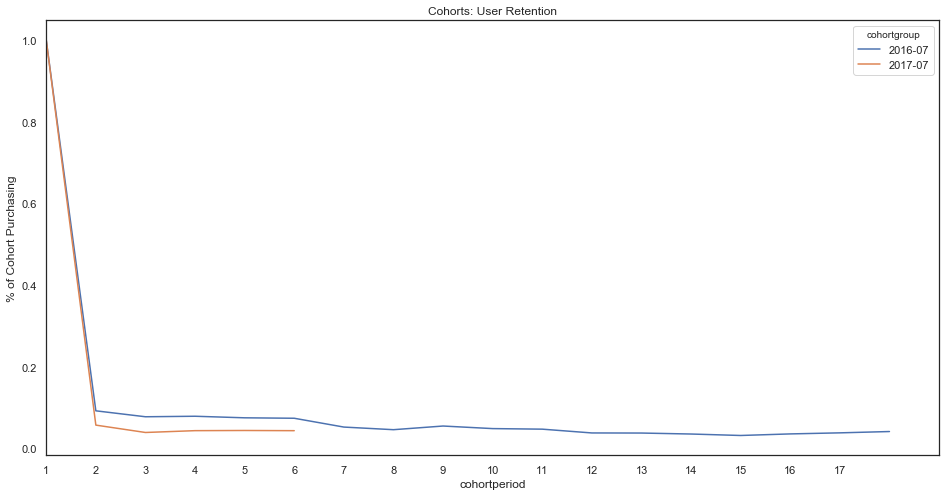

In [307]:
#Посмотрим на количество и процент покупок в когортных группах'2016-07' и '2017-08' 

user_retention[['2016-07', '2017-07']].plot(figsize=(16,8))
plt.title('Cohorts: User Retention')
plt.xticks(np.arange(1, 17.1, 1))
plt.xlim(1, 19)
plt.ylabel('% of Cohort Purchasing');

Видно, что длина или количество повторяющихся покупок группы 'июль 2016' года больше в три раза, чем у группы за 'июль 2017'

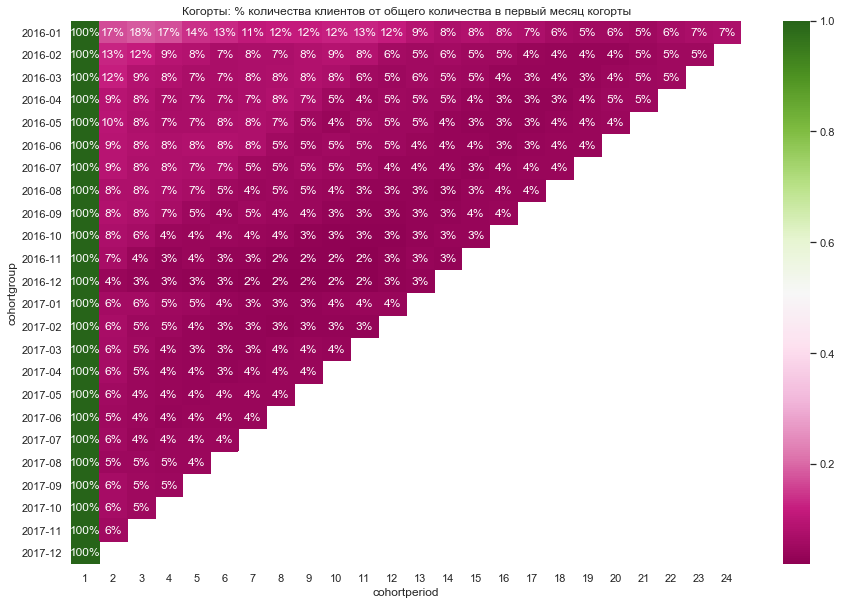

In [318]:
import seaborn as sns
sns.set(style='white')

plt.figure(figsize=(15, 10))
plt.title('Когорты: % количества клиентов от общего количества в первый месяц когорты')
sns.heatmap(user_retention.T, mask=user_retention.T.isnull(), annot=True, fmt='.0%', cmap = 'PiYG')

Можно оценить лояльность покупателей 2016 года, которые по-прежнему активно участвуют в продажах 2017.

**Когортный анализ по сумме продажам**

In [309]:
#Посчитаем количество клиентов в каждой когортной группе
cohort_group_sum = cohorts['totalsum'].groupby(level=0).first()

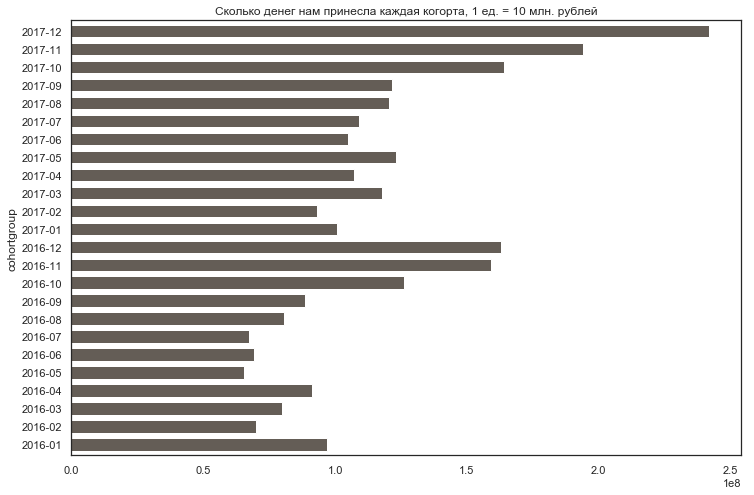

In [395]:
cohort_group_sum.round(0).plot.barh(title='Сколько денег нам принесла каждая когорта, 1 ед. = 10 млн. рублей', 
                                   color='#645D56', width = 0.7 )

Несмотря на то, что многие клиенты еще живут с начала 2016 года, лидерами по вкладу в объем продаж являются когорты за последние 3 месяца.

In [311]:
cohorts['totalsum'].head()

cohortgroup  cohortperiod
2016-01      1               9.681233e+07
             2               2.546869e+07
             3               2.561764e+07
             4               2.666818e+07
             5               1.985025e+07
Name: totalsum, dtype: float64

In [ ]:
#Определим долю повторной покупки исходя из суммы покупок в каждой группе

In [312]:
cohorts['totalsum'].unstack(0).head()

cohortgroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohortperiod,,,,,,,,,,,,,,,,,,,,,
1,9.681233e+07,6.996784e+07,7.995560e+07,9.126609e+07,6.534688e+07,6.943189e+07,6.734067e+07,8.056880e+07,8.856474e+07,1.262921e+08,...,1.179343e+08,1.071647e+08,1.231310e+08,1.049773e+08,1.089948e+08,1.206460e+08,1.216816e+08,1.640169e+08,1.942136e+08,2.418661e+08
2,2.546869e+07,9.697390e+06,1.174599e+07,8.773005e+06,7.395215e+06,6.967969e+06,7.144969e+06,7.572620e+06,9.716036e+06,1.444679e+07,...,8.522249e+06,8.446128e+06,8.428332e+06,8.865895e+06,8.090613e+06,7.973636e+06,1.027735e+07,1.629159e+07,1.306699e+07,NaN
3,2.561764e+07,9.643754e+06,7.555766e+06,7.379729e+06,5.916286e+06,7.031031e+06,5.848848e+06,7.385930e+06,8.209034e+06,1.177591e+07,...,7.582773e+06,5.354919e+06,6.310730e+06,6.988671e+06,4.889046e+06,7.102997e+06,7.751645e+06,1.188618e+07,NaN,NaN
4,2.666818e+07,7.061442e+06,7.256456e+06,6.028443e+06,5.604741e+06,6.322237e+06,6.650946e+06,7.140676e+06,7.175255e+06,7.998471e+06,...,5.049831e+06,4.915243e+06,5.500454e+06,6.004255e+06,5.646042e+06,6.307841e+06,6.455291e+06,NaN,NaN,NaN
5,1.985025e+07,6.251231e+06,5.868719e+06,6.635924e+06,5.400168e+06,7.309049e+06,5.832119e+06,6.211531e+06,5.041844e+06,6.296567e+06,...,4.657071e+06,4.188225e+06,5.028742e+06,5.937972e+06,5.469260e+06,5.998446e+06,NaN,NaN,NaN,NaN


In [313]:
user_retention_sales = cohorts['totalsum'].unstack(0).divide(cohort_group_sum, axis=1)

In [314]:
user_retention_sales.head()

cohortgroup,2016-01,2016-02,2016-03,2016-04,2016-05,2016-06,2016-07,2016-08,2016-09,2016-10,...,2017-03,2017-04,2017-05,2017-06,2017-07,2017-08,2017-09,2017-10,2017-11,2017-12
cohortperiod,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
2,0.263073,0.138598,0.146906,0.096126,0.113169,0.100357,0.106102,0.093989,0.109705,0.114392,...,0.072263,0.078814,0.068450,0.084455,0.074229,0.066091,0.084461,0.099329,0.067282,NaN
3,0.264611,0.137831,0.094500,0.080859,0.090537,0.101265,0.086855,0.091672,0.092690,0.093243,...,0.064297,0.049969,0.051252,0.066573,0.044856,0.058875,0.063704,0.072469,NaN,NaN
4,0.275463,0.100924,0.090756,0.066053,0.085769,0.091057,0.098766,0.088628,0.081017,0.063333,...,0.042819,0.045866,0.044672,0.057196,0.051801,0.052284,0.053051,NaN,NaN,NaN
5,0.205038,0.089344,0.073400,0.072710,0.082639,0.105269,0.086606,0.077096,0.056928,0.049857,...,0.039489,0.039082,0.040841,0.056564,0.050179,0.049719,NaN,NaN,NaN,NaN


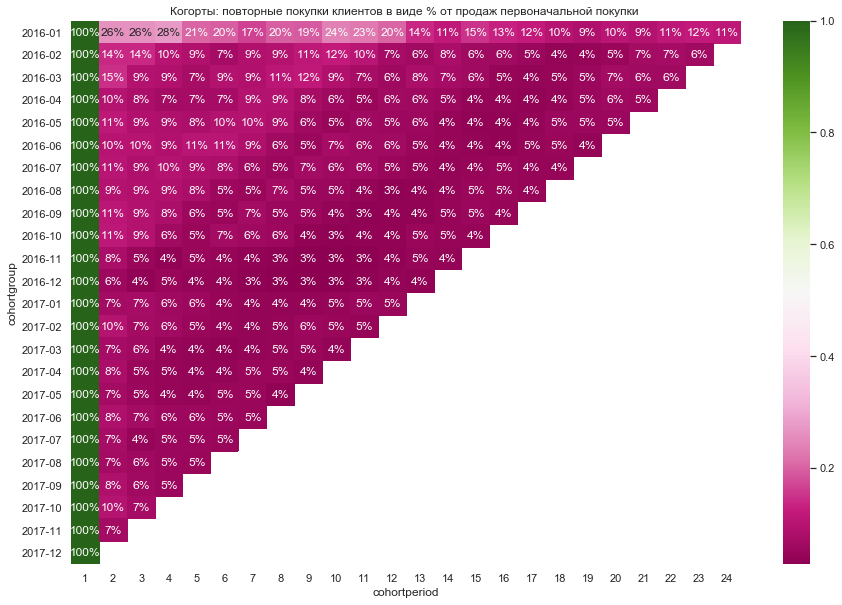

In [317]:
import seaborn as sns
sns.set(style='white')
plt.figure(figsize=(15, 10))
plt.title('Когорты: повторные покупки клиентов в виде % от продаж первоначальной покупки ')
sns.heatmap(user_retention_sales.T, mask=user_retention_sales.T.isnull(),  annot=True, fmt='.0%', cmap='PiYG')

cohortperiod,1,2,3,4,5,6,7,8,9,10,...,15,16,17,18,19,20,21,22,23,24
cohortgroup,,,,,,,,,,,,,,,,,,,,,
2016-01,1.0,0.263073,0.264611,0.275463,0.205038,0.195863,0.166618,0.196066,0.193574,0.238530,...,0.150390,0.131613,0.121039,0.100792,0.086331,0.103599,0.092331,0.113141,0.119883,0.111267
2016-02,1.0,0.138598,0.137831,0.100924,0.089344,0.070591,0.089185,0.093691,0.111440,0.120741,...,0.064522,0.061976,0.053574,0.041120,0.044773,0.046328,0.066608,0.070917,0.064990,NaN
2016-03,1.0,0.146906,0.094500,0.090756,0.073400,0.091985,0.091140,0.109257,0.115372,0.091821,...,0.064157,0.045758,0.041039,0.045768,0.053063,0.067573,0.064517,0.064851,NaN,NaN
2016-04,1.0,0.096126,0.080859,0.066053,0.072710,0.072596,0.092231,0.094556,0.076377,0.058712,...,0.039629,0.038984,0.038430,0.041243,0.053565,0.059340,0.054497,NaN,NaN,NaN
2016-05,1.0,0.113169,0.090537,0.085769,0.082639,0.095432,0.095947,0.085271,0.059331,0.047568,...,0.037385,0.038374,0.041801,0.052036,0.051499,0.051210,NaN,NaN,NaN,NaN
2016-06,1.0,0.100357,0.101265,0.091057,0.105269,0.106339,0.088030,0.061746,0.053435,0.071837,...,0.040214,0.037025,0.046226,0.049226,0.041563,NaN,NaN,NaN,NaN,NaN
2016-07,1.0,0.106102,0.086855,0.098766,0.086606,0.080901,0.061875,0.053181,0.069092,0.060605,...,0.042730,0.049695,0.044136,0.043189,NaN,NaN,NaN,NaN,NaN,NaN
2016-08,1.0,0.093989,0.091672,0.088628,0.077096,0.054560,0.049359,0.066046,0.052984,0.050535,...,0.046779,0.047534,0.044111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09,1.0,0.109705,0.092690,0.081017,0.056928,0.049460,0.065475,0.053006,0.051189,0.040214,...,0.050628,0.044512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Из предыдущей работы по этим данным, используя метод ARIMA, прогноз продаж на январь 2018 составляет 389823293 рублей.

In [ ]:
jan_2018_sales = 389823293

**Спрогнозируем, какую долю из этих продаж будут вносить клиенты из когорт предыдущих период**

1. Создадим итоговую таблицу

In [322]:
dfs= df['price'].groupby(by=df.o_period).sum().round(0).reset_index()

In [326]:
#Восстановим индекс 
cohorts.reset_index(inplace=True)

In [327]:
#Создадим столбец с первым месяцем продаж в каждой когорте, чтобы знать объем новых клиентов по каждой когорте
dfs['newsales']= [x for x in cohorts['totalsum'].loc[(cohorts['cohortperiod'] ==1)].round(0)]

In [328]:
#Посчитаем долю новых клиентов от суммы продаж в каждой когорте
dfs['sharenewsales'] = (dfs['newsales'] / dfs['price'] )*100

2. Определим долю старых и новых клиентов в прогнозе на январь 2018

In [329]:
#Возьмем среднее значение новых клиентов за 2017 год -?????
new_sales_2017_mean = round(dfs.sharenewsales[12:].mean(), 1)

In [334]:
new_sales_2017_mean

57.8

In [338]:
#Посчитаем объем продаж от старых клиентов в январе 2018 года 
old_sales_jan_2018 = round(new_sales_2017_mean*jan_2018_sales, 0)/100

In [340]:
#Определим долю новых клиентов продажах на январь 2018
new_sales_jan_2018 = jan_2018_sales - old_sales_jan_2018

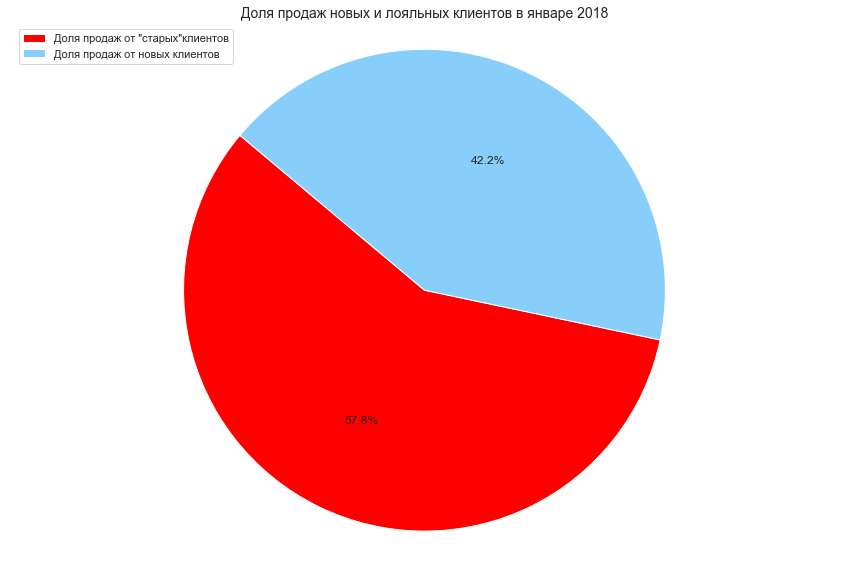

In [343]:
plt.figure(figsize=(12,8))
plt.title('Доля продаж новых и лояльных клиентов в январе 2018 ', fontsize=14)
labels = ['Доля продаж от "старых"клиентов', 'Доля продаж от новых клиентов']
sizes = [old_sales_jan_2018, new_sales_jan_2018]
colors = ['red', 'lightskyblue']
plt.pie(sizes, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
plt.legend(labels, loc="best")
plt.axis('equal')
plt.tight_layout()
plt.show()

Определили, что 57.8% от прогнозируемого объема продаж в январе 2018 будут от покупок уже лояльных клиентов

3. Определим вклад каждой когорты в долю продаж от старых клиентов: 

In [349]:
#Возьмем последнее значение доли каждой когорты для прогноза в январе 2018 
cohort_last = []
for i in user_retention_sales.columns:
    b = user_retention_sales[i][user_retention_sales[i].notnull()][-1:].values[0]
    if b !=1:
        cohort_last.append(b)
    else:
        b = cohort_last[-1]
        cohort_last.append(b)

In [353]:
user_retention_sales.columns

Index(['2016-01', '2016-02', '2016-03', '2016-04', '2016-05', '2016-06',
       '2016-07', '2016-08', '2016-09', '2016-10', '2016-11', '2016-12',
       '2017-01', '2017-02', '2017-03', '2017-04', '2017-05', '2017-06',
       '2017-07', '2017-08', '2017-09', '2017-10', '2017-11', '2017-12'],
      dtype='object', name='cohortgroup')

In [354]:
#создадим столбец с последним значением % от продаж по каждой когорте
dfs['last_share_cohort'] = cohort_last 

In [355]:
#доля когорты в деньгах от продаж
dfs['last_share_cohort_money'] = dfs['newsales']*dfs['last_share_cohort']

In [356]:
#вычислим долю каждой когорты исходя из общего объем продаж 
sum_m = dfs['last_share_cohort_money'].sum()
dfs['cohort_share_index'] = [x/sum_m for x in dfs['last_share_cohort_money']]

In [357]:
#определим долю каждой когорты в продажа на январь 2018 года 
dfs['share_jan_2018'] = dfs['cohort_share_index']*old_sales_jan_2018

In [358]:
#Сделаем из периода индекс
dfs.set_index('o_period', inplace=True)

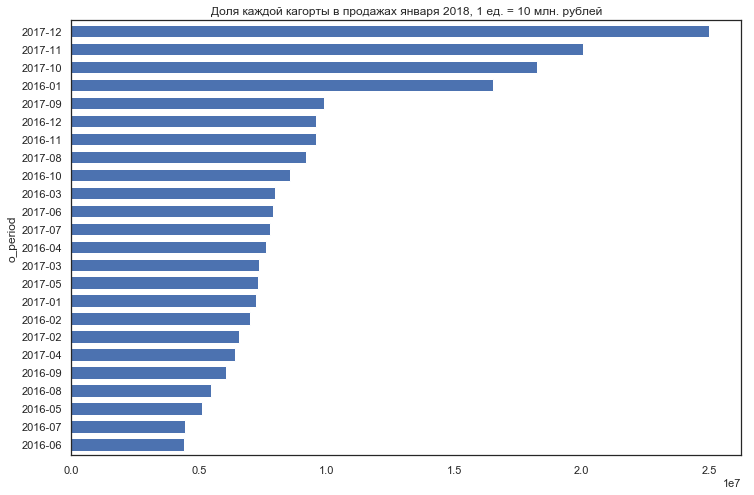

In [396]:
dfs.share_jan_2018.round(0).sort_values(ascending = True)\
.plot.barh(title='Доля каждой кагорты в продажах января 2018, 1 ед. = 10 млн. рублей', width = 0.7)

**Резюме:** 
    
Стоит активно инвестировать в новых клиентов, так как лояльность клиентов за последние 3 месяца входит в топ 3 когорты по вкладу в новые продажи. Для более подробного анализа инвестиций в маркетинг и их возврата, необходимо знать стоимость привлечения нового клиента.